In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
entire_set = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        complete_path = os.path.join(dirname, filename)
        if 'README' not in complete_path:
            entire_set.append(complete_path)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/flowers-dataset
/kaggle/input/flowers-dataset/valid
/kaggle/input/flowers-dataset/valid/dandelion
/kaggle/input/flowers-dataset/valid/daisy
/kaggle/input/flowers-dataset/test
/kaggle/input/flowers-dataset/test/dandelion
/kaggle/input/flowers-dataset/test/daisy
/kaggle/input/flowers-dataset/train
/kaggle/input/flowers-dataset/train/dandelion
/kaggle/input/flowers-dataset/train/daisy


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
IMG_SIZE = (250, 250)
dirname = '/kaggle/input/flowers-dataset/'
validation_set = image_dataset_from_directory(dirname + 'valid/',
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=IMG_SIZE)
train_dataset = image_dataset_from_directory(dirname + 'train/',
                                           shuffle=True,
                                           batch_size=32,
                                           image_size=IMG_SIZE)
test_set = image_dataset_from_directory(dirname + 'test/',
                                       shuffle=True,
                                       image_size=IMG_SIZE)
print(train_dataset)
print(validation_set)
print(test_set)
# print(*entire_set, sep='\n')


Found 364 files belonging to 2 classes.
Found 1275 files belonging to 2 classes.
Found 182 files belonging to 2 classes.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


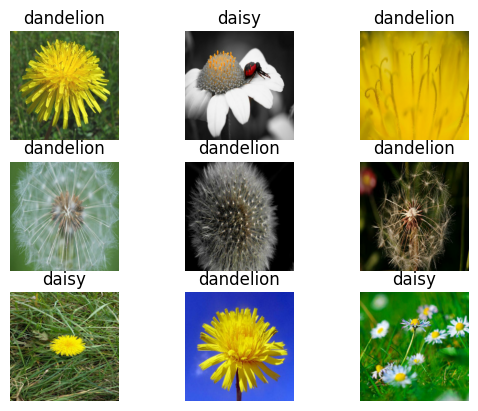

In [5]:
class_names = train_dataset.class_names
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    data_augumentation = tf.keras.Sequential()
    data_augumentation.add(RandomFlip('horizontal'))
    data_augumentation.add(RandomRotation(0.2))
    return data_augumentation

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [9]:
def flower_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,) 
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                  include_top=False,
                                                  weights='imagenet')
    base_model.trainable=False
    input_layer = tf.keras.Input(shape=input_shape)
    x = data_augmentation(input_layer)
    x = preprocess_input(x)
    x = base_model(x, training=False) # !!!! IMPORTANT!!!
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    output_layer = tfl.Dense(1)(x)
    model = tf.keras.Model(input_layer, output_layer)
    return model

In [10]:
def flower_model_inception(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,) 
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape,
                                                  include_top=False,
                                                  weights='imagenet')
    base_model.trainable=False
    input_layer = tf.keras.Input(shape=input_shape)
    x = data_augmentation(input_layer)
    x = tf.keras.applications.inception_v3.preprocess_input(x)
    x = base_model(x, training=False) # !!!! IMPORTANT!!!
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
    output_layer = tfl.Dense(1)(x)
    model = tf.keras.Model(input_layer, output_layer)
    return model

In [11]:
model_flowers = flower_model()

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
model_with_inception = flower_model_inception()

87910968/87910968 [==============================] - 0s 0us/step


In [13]:
base_learning_rate = 0.001
model_flowers.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [14]:
initial_epochs = 10
history1 = model_flowers.fit(train_dataset, validation_data = validation_set, epochs=initial_epochs)

Epoch 1/10
40/40 [==============================] - 16s 152ms/step - loss: 0.5738 - accuracy: 0.6839 - val_loss: 0.3520 - val_accuracy: 0.8599
Epoch 2/10
40/40 [==============================] - 4s 82ms/step - loss: 0.3002 - accuracy: 0.8541 - val_loss: 0.2685 - val_accuracy: 0.8819
Epoch 3/10
40/40 [==============================] - 3s 81ms/step - loss: 0.2375 - accuracy: 0.8980 - val_loss: 0.2333 - val_accuracy: 0.8874
Epoch 4/10
40/40 [==============================] - 3s 79ms/step - loss: 0.2032 - accuracy: 0.9169 - val_loss: 0.2166 - val_accuracy: 0.8984
Epoch 5/10
40/40 [==============================] - 3s 79ms/step - loss: 0.1887 - accuracy: 0.9161 - val_loss: 0.2041 - val_accuracy: 0.9176
Epoch 6/10
40/40 [==============================] - 3s 80ms/step - loss: 0.1803 - accuracy: 0.9208 - val_loss: 0.2005 - val_accuracy: 0.9148
Epoch 7/10
40/40 [==============================] - 4s 82ms/step - loss: 0.1698 - accuracy: 0.9349 - val_loss: 0.2049 - val_accuracy: 0.9066
Epoch 8/10


In [15]:
def plot_detais(history):
    acc = [0.] + history.history['accuracy']
    val_acc = [0.] + history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.xlabel('epoch')
    plt.show()

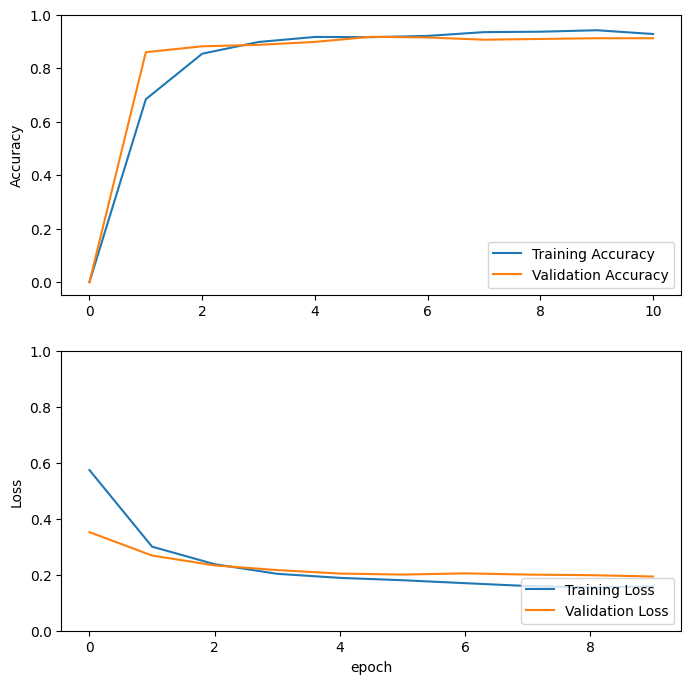

In [16]:
plot_detais(history1)

In [17]:
model_with_inception.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                            metrics=['accuracy'])

In [18]:
history_inception = model_with_inception.fit(train_dataset, validation_data = validation_set, epochs=10)

Epoch 1/10
40/40 [==============================] - 16s 222ms/step - loss: 0.3812 - accuracy: 0.8094 - val_loss: 0.2192 - val_accuracy: 0.8819
Epoch 2/10
40/40 [==============================] - 5s 111ms/step - loss: 0.2043 - accuracy: 0.9075 - val_loss: 0.1960 - val_accuracy: 0.8956
Epoch 3/10
40/40 [==============================] - 5s 112ms/step - loss: 0.1790 - accuracy: 0.9216 - val_loss: 0.1780 - val_accuracy: 0.9011
Epoch 4/10
40/40 [==============================] - 5s 111ms/step - loss: 0.1644 - accuracy: 0.9255 - val_loss: 0.1620 - val_accuracy: 0.9011
Epoch 5/10
40/40 [==============================] - 5s 113ms/step - loss: 0.1485 - accuracy: 0.9365 - val_loss: 0.1614 - val_accuracy: 0.9038
Epoch 6/10
40/40 [==============================] - 5s 111ms/step - loss: 0.1455 - accuracy: 0.9388 - val_loss: 0.1602 - val_accuracy: 0.9093
Epoch 7/10
40/40 [==============================] - 5s 112ms/step - loss: 0.1376 - accuracy: 0.9467 - val_loss: 0.1972 - val_accuracy: 0.9066
Epoch

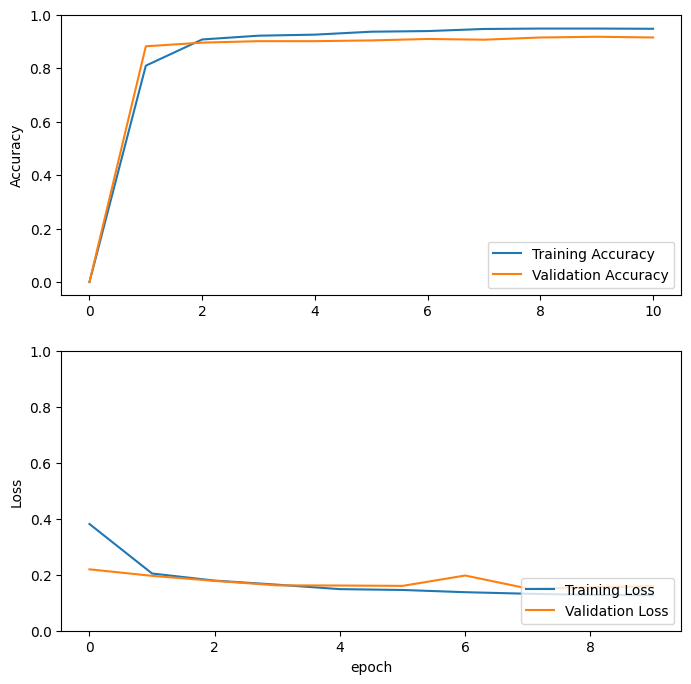

In [19]:
plot_detais(history_inception)

In [30]:
def flower_model_tuned_inception(model_trained, layers_trainable=40):
    base_model = model_trained.layers[4]
    layers_non_trainable = len(base_model.layers) - layers_trainable
    base_model.trainable=True
    for lay in base_model.layers[:layers_non_trainable]:
        lay.trainable = False
    model_trained.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                            metrics=['accuracy'])
    return model_trained

In [31]:
tuned_model = flower_model_tuned_inception(model_with_inception)

In [32]:
history_fine = tuned_model.fit(train_dataset, validation_data = validation_set, epochs=10 + 5, initial_epoch=history_inception.epoch[-1])

Epoch 10/15
40/40 [==============================] - 17s 168ms/step - loss: 0.4711 - accuracy: 0.8769 - val_loss: 0.1250 - val_accuracy: 0.9341
Epoch 11/15
40/40 [==============================] - 5s 125ms/step - loss: 0.0934 - accuracy: 0.9600 - val_loss: 0.1079 - val_accuracy: 0.9451
Epoch 12/15
40/40 [==============================] - 5s 128ms/step - loss: 0.0587 - accuracy: 0.9780 - val_loss: 0.1270 - val_accuracy: 0.9505
Epoch 13/15
40/40 [==============================] - 5s 122ms/step - loss: 0.0458 - accuracy: 0.9780 - val_loss: 0.1241 - val_accuracy: 0.9560
Epoch 14/15
40/40 [==============================] - 5s 123ms/step - loss: 0.0372 - accuracy: 0.9890 - val_loss: 0.1401 - val_accuracy: 0.9533
Epoch 15/15
40/40 [==============================] - 5s 123ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.1294 - val_accuracy: 0.9615


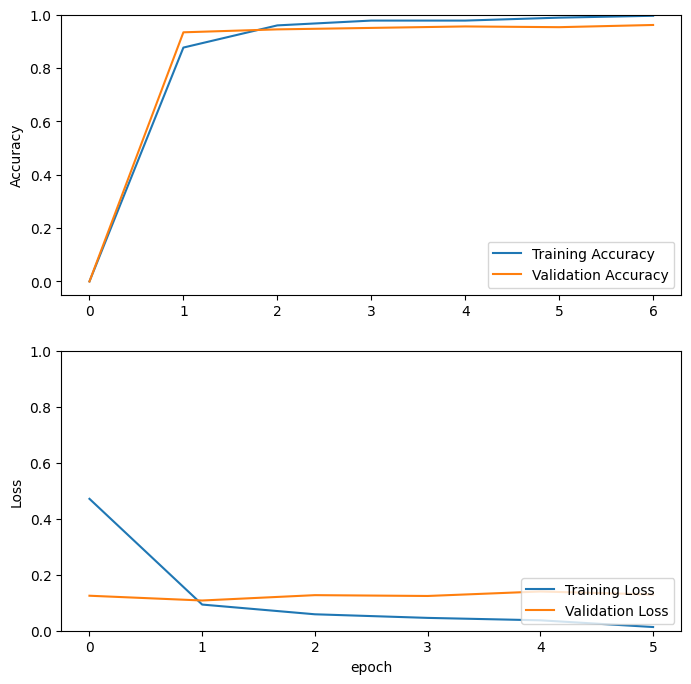

In [33]:
plot_detais(history_fine)
# cam face overfitting...ayae

In [41]:
predictions= tuned_model.predict(test_set)
tuned_model.evaluate(test_set)[1]
#eh...se putea si mai bine dar ayae

6/6 [==============================] - 1s 74ms/step - loss: 0.1667 - accuracy: 0.9505


0.9505494236946106